# Book Reading Propensity: Create Train/Test Sets

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import os

import matplotlib.pyplot as plt

%matplotlib inline

## Read the Data

In [2]:
df = pd.read_csv('./data/goodreads_pairs_2016_enhanced.csv',
                dtype={'book_id':'Int64', 
                       'month': np.uint8, 'day': np.uint8, 'hour': np.uint8,
                       'rating': np.uint8})

In [3]:
df.shape

(3813915, 6)

In [4]:
df.head()

,user_id,book_id,month,day,hour,rating
0,8842281e1d1347389f2ab93d60773d4d,29058155,12,13,11,3
1,8842281e1d1347389f2ab93d60773d4d,10673579,1,8,1,5
2,8842281e1d1347389f2ab93d60773d4d,76620,12,14,12,5
3,7504b2aee1ecb5b2872d3da381c6c91e,29069989,8,17,19,2
4,7504b2aee1ecb5b2872d3da381c6c91e,8882815,6,21,16,3


In [5]:
df.dtypes

user_id    object
book_id     Int64
month       uint8
day         uint8
hour        uint8
rating      uint8
dtype: object

## Create a Label/Target: "Would Recommend"

In [6]:
df['would_recommend'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)
df.head()

,user_id,book_id,month,day,hour,rating,would_recommend
0,8842281e1d1347389f2ab93d60773d4d,29058155,12,13,11,3,0
1,8842281e1d1347389f2ab93d60773d4d,10673579,1,8,1,5,1
2,8842281e1d1347389f2ab93d60773d4d,76620,12,14,12,5,1
3,7504b2aee1ecb5b2872d3da381c6c91e,29069989,8,17,19,2,0
4,7504b2aee1ecb5b2872d3da381c6c91e,8882815,6,21,16,3,0


## Basic EDA

In [6]:
print(f'Total number of Readers: {df.user_id.nunique():,}')

Total number of Readers: 304,842


In [7]:
print(f'Total number of Unique Book Titles: {df.book_id.nunique():,}')

Total number of Unique Book Titles: 165,407


In [32]:
# Checking for duplicate reader-book pairs
print(f'Total number of Rows in the Dataset:      {df.shape[0]:>10,d}')

n_unique_pairs = (df.user_id + " " + df.book_id.astype(str)).nunique()
print(f'Total number of Unique Reader-Book Pairs: {n_unique_pairs:>10,d}')

Total number of Rows in the Dataset:       3,813,915
Total number of Unique Reader-Book Pairs:  3,813,915


In [36]:
# Estimating the sparsity
sparsity = (df.shape[0] / (df.user_id.nunique() * df.book_id.nunique())) * 100
print(f'Rating Matrix Sparsity:      {sparsity:.5f}%')

Rating Matrix Sparsity:      0.00756%


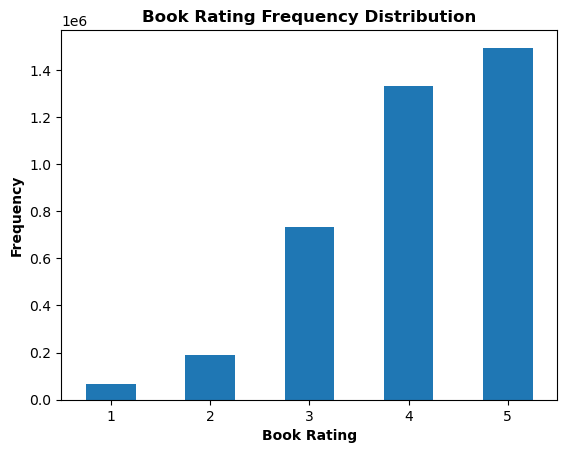

In [25]:
df.groupby('rating')['book_id'].count().plot.bar();
plt.title('Book Rating Frequency Distribution', weight='bold');
plt.xticks(rotation=0);
plt.xlabel('Book Rating', weight='bold');
plt.ylabel('Frequency', weight='bold');

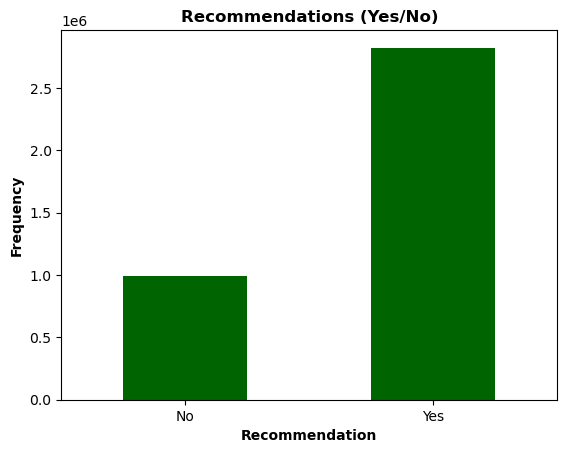

In [28]:
df.groupby('would_recommend')['book_id'].count().plot.bar(color='darkgreen');
plt.title('Recommendations (Yes/No)', weight='bold');
plt.xticks(ticks=[0,1], labels=['No', 'Yes'], rotation=0);
plt.xlabel('Recommendation', weight='bold');
plt.ylabel('Frequency', weight='bold');

## Create the Train/Test Sets

In [9]:
df.head()

,user_id,book_id,month,day,hour,rating,would_recommend
0,8842281e1d1347389f2ab93d60773d4d,29058155,12,13,11,3,0
1,8842281e1d1347389f2ab93d60773d4d,10673579,1,8,1,5,1
2,8842281e1d1347389f2ab93d60773d4d,76620,12,14,12,5,1
3,7504b2aee1ecb5b2872d3da381c6c91e,29069989,8,17,19,2,0
4,7504b2aee1ecb5b2872d3da381c6c91e,8882815,6,21,16,3,0


In [7]:
df_train_val = df[df.month < 12]
df_test = df[df.month == 12]
print(f'Train/Val Set: {df_train_val.shape[0]:>10,d} rows')
print(f'Test Set:      {df_test.shape[0]:>10,d} rows')

Train/Val Set:  3,491,950 rows
Test Set:         321,965 rows


In [16]:
df['rating_train'] = 0
df.loc[df['month'] < 12, 'rating_train'] = df['rating']

df['rating_test'] = 0
df.loc[df['month'] == 12, 'rating_test'] = df['rating']

df[['month', 'rating', 'rating_train', 'rating_test']].head()

,month,rating,rating_train,rating_test
0,12,3,0,3
1,1,5,5,0
2,12,5,0,5
3,8,2,2,0
4,6,3,3,0


## Save the Results

In [17]:
df.head()

,user_id,book_id,month,day,hour,rating,would_recommend,rating_train,rating_test
0,8842281e1d1347389f2ab93d60773d4d,29058155,12,13,11,3,0,0,3
1,8842281e1d1347389f2ab93d60773d4d,10673579,1,8,1,5,1,5,0
2,8842281e1d1347389f2ab93d60773d4d,76620,12,14,12,5,1,0,5
3,7504b2aee1ecb5b2872d3da381c6c91e,29069989,8,17,19,2,0,2,0
4,7504b2aee1ecb5b2872d3da381c6c91e,8882815,6,21,16,3,0,3,0


In [23]:
train_val_path = './data/goodreads_2016_train_val.csv'
df[['user_id', 'book_id', 'rating_train']].\
            rename(columns={'rating_train': 'rating'}).\
            to_csv(train_val_path, index=False)

pd.read_csv(train_val_path).head()

,user_id,book_id,rating
0,8842281e1d1347389f2ab93d60773d4d,29058155,0
1,8842281e1d1347389f2ab93d60773d4d,10673579,5
2,8842281e1d1347389f2ab93d60773d4d,76620,0
3,7504b2aee1ecb5b2872d3da381c6c91e,29069989,2
4,7504b2aee1ecb5b2872d3da381c6c91e,8882815,3


In [22]:
test_path = './data/goodreads_2016_test.csv'
df[['user_id', 'book_id', 'rating_test']].\
            rename(columns={'rating_test': 'rating'}).\
            to_csv(test_path, index=False)

pd.read_csv(test_path).head()

,user_id,book_id,rating
0,8842281e1d1347389f2ab93d60773d4d,29058155,3
1,8842281e1d1347389f2ab93d60773d4d,10673579,0
2,8842281e1d1347389f2ab93d60773d4d,76620,5
3,7504b2aee1ecb5b2872d3da381c6c91e,29069989,0
4,7504b2aee1ecb5b2872d3da381c6c91e,8882815,0


In [ ]:
# df_ratings = df.groupby(['user_id', 'book_id'])['rating'].last().unstack()

/Users/kostyamostya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/reshape.py:134: PerformanceWarning: The following operation may generate 50423000694 cells in the resulting pandas object.
  warnings.warn(


In [41]:
df_ratings.head()

user_id                           book_id
00000377eea48021d3002730d56aca9a  2          5
                                  3          5
                                  14497      5
                                  15881      5
                                  1482132    5
Name: rating, dtype: uint8